Примение уже обученной модели.

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import os
import json
from torch_geometric.utils import dense_to_sparse
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from tqdm.notebook import tqdm

#Custom imports
import GCN
from Graph import Graph

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
model_diversity_path = "weights_models_cifar/model_diversity_weights.pth"
model_accuracy_path = "weights_models_cifar/model_accuracy_weights.pth"

In [3]:
input_dim = 8
output_dim = 16
dropout=0.1

model_diverisity = GCN.GCN(input_dim, output_dim, dropout).to(device)
state_dict = torch.load(model_diversity_path, map_location=device, weights_only=True)
model_diverisity.load_state_dict(state_dict)
model_diverisity.eval()

GCN(
  (gc1): GCNConv(8, 128)
  (gc2): GCNConv(128, 256)
  (gc3): GCNConv(256, 64)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=64, out_features=16, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (key): Linear(in_features=256, out_features=256, bias=True)
  (query): Linear(in_features=256, out_features=256, bias=True)
  (residual_proj): Linear(in_features=8, out_features=64, bias=True)
)

In [4]:
input_dim = 8
output_dim = 1
dropout = 0
model_accuracy = GCN.GCN(input_dim, output_dim, dropout).to(device)
state_dict = torch.load(model_accuracy_path, map_location=device, weights_only=True)
model_accuracy.load_state_dict(state_dict)
model_accuracy.eval()

GCN(
  (gc1): GCNConv(8, 128)
  (gc2): GCNConv(128, 256)
  (gc3): GCNConv(256, 64)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (key): Linear(in_features=256, out_features=256, bias=True)
  (query): Linear(in_features=256, out_features=256, bias=True)
  (residual_proj): Linear(in_features=8, out_features=64, bias=True)
)

In [5]:
def load_json_from_directory(directory_path):
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data

In [6]:
architecture_path = "dataset"
arch_dicts = load_json_from_directory(architecture_path)[0] # return array of dicts, but this json contains all dicts
arch_dicts = [{"architecture": tmp_dict, "test_predictions":None} for tmp_dict in arch_dicts]

In [7]:
graph = Graph(arch_dicts[1])

In [8]:
graphs = [Graph(model_dict, index=i) for (i, model_dict) in enumerate(arch_dicts)]

In [9]:
dataset = GCN.CustomDataset(graphs)

100%|██████████| 100/100 [00:00<00:00, 186.26it/s]


In [21]:
def extract_embeddings(model, dataset, device, use_tqdm=True):
    model.to(device)
    model.eval()
    embeddings = []
    indices = []

    iterator = tqdm(dataset) if use_tqdm else dataset

    with torch.no_grad():
        for data in iterator:
            adj, features, index = data

            adj = adj.to(device)
            features = features.to(device)

            edge_index, _ = dense_to_sparse(adj)

            embedding = model(features, edge_index)

            embeddings.append(embedding.cpu().numpy())
            indices.append(index)

    embeddings = np.vstack(embeddings)
    return embeddings, indices


def visualize_clusters(
    model, train_dataset, device="cpu", min_samples=3, xi=0.025, min_cluster_size=3
):
    """
    Визуализирует кластеры, используя PCA для уменьшения размерности и OPTICS для кластеризации.

    Аргументы:
      model: Обученная модель для извлечения эмбеддингов.
      train_dataset: Датасет для обучения.
      device: Устройство для вычислений ("cpu" или "cuda").
      min_samples: Минимальное количество образцов для формирования кластера в OPTICS.
      xi: Параметр для определения устойчивости кластеров в OPTICS.
      min_cluster_size: Минимальный размер кластера в OPTICS.
    """
    # Извлечение эмбеддингов
    embeddings, indices = extract_embeddings(model, train_dataset, device=device)

    # Преобразование эмбеддингов в 2D с помощью PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    # Кластеризация с помощью OPTICS
    optics = OPTICS(
        min_samples=min_samples,
        xi=xi,
        min_cluster_size=min_cluster_size,
        metric="euclidean",
    )
    clusters = optics.fit_predict(embeddings)

    # Визуализация кластеров
    plt.figure(figsize=(8, 6.5))
    scatter = plt.scatter(
        embeddings_2d[:, 0],
        embeddings_2d[:, 1],
        c=clusters,
        cmap="tab10",
        s=np.where(clusters == -1, 20, 70),
        alpha=np.where(clusters == -1, 0.5, 1),
    )
    plt.xlabel("PCA Component 1", fontsize=16)
    plt.ylabel("PCA Component 2", fontsize=16)

    # Создание легенды для кластеров
    unique_clusters = np.unique(clusters)
    for cluster in tqdm(unique_clusters):
        if cluster == -1:
            label = "Noise"
        else:
            label = f"Cluster {cluster}"
        plt.scatter(
            [],
            [],
            color=scatter.cmap(scatter.norm(cluster)),
            label=label,
            s=50 if cluster != -1 else 20,
        )

    plt.gca().set_facecolor("lightgrey")
    plt.show()

    return clusters

Разобьем модели на кластеры. 

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

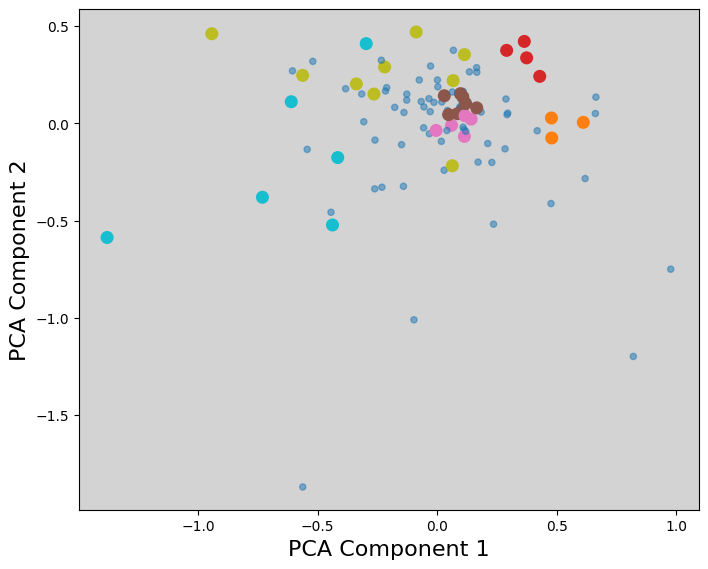

In [11]:
clusters = visualize_clusters(
  model_diverisity,
  dataset,
  device=device,
  min_samples=3,
  xi=0.025,
  min_cluster_size=3
)

In [12]:
cluster_indexes = np.where(clusters == 0)[0]

In [13]:
max_cluster = np.max(clusters)
cluster_indexes = [np.where(clusters == i)[0] for i in range(max_cluster + 1)]

In [40]:
cluster_indexes = sorted(cluster_indexes, key=len, reverse=True)
cluster_indexes

[array([ 4, 17, 25, 29, 45, 48, 76, 84, 89]),
 array([ 5, 20, 31, 33, 36, 81, 91, 95]),
 array([39, 64, 72, 79, 85, 93]),
 array([ 2, 16, 41, 67, 87]),
 array([22, 63, 98, 99]),
 array([28, 57, 68])]

Для каждого кластера найдем модель с наибольшей точностью

In [ ]:
best_models = []

for indexes in  cluster_indexes[:5]:
    embeddings, indices = extract_embeddings(
    model_accuracy,
    dataset[indexes],
    device=device,
    use_tqdm=False
    )

    best_model_index = indices[np.argmax(embeddings)]
    best_models.append(arch_dicts[best_model_index]["architecture"])

In [34]:
def save_best_models(best_models, output_directory="best_models"):
    os.makedirs(output_directory, exist_ok=True)

    for i, model in enumerate(best_models):
        file_path = os.path.join(output_directory, f"model_{i}.json")
        with open(file_path, "w", encoding="utf-8") as f:
            json.dump(model, f, ensure_ascii=False, indent=4)

In [35]:
save_best_models(best_models)